In [6]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as const
import time

import Bell_EBM as ebm

In [10]:
planetPrime = ebm.Planet('gas', rad=1.900*const.R_jup.value, mass=1.470*const.M_jup.value,
                    Porb=1.09142030, a=0.02340*const.au.value, inc=83.37, vWind=5e3, e=0.4)
starPrime = star = ebm.Star(teff=6300., rad=1.59)
verbose = True

planet = planetPrime
star = starPrime

# #==========Set Up System==========
# in_rad = 1.900 #Times that or Jupiter
# in_mass = 1.470 #Times that of Jupiter
# in_orb = 1.09142030 #Orbital period in days
# in_a = 0.02340 #Semi Major Axis in AU
# in_inc = 83. #Planet's inclination
# in_e = 0.5

# s_in_teff = 6300.
# s_in_rad = 1.59

#Allowed error ppm
aError = 20

In [11]:
#==========High Res Baseline Creation==========
tInt = time.time()
if (verbose == True): 
    print("Starting baseline generation...")
    
baseUpdates = 3000. #Amount of timesteps in baseline
baseOrbits = 2 #Amount of orbits in baseline

planet.map = ebm.Map.Map(nlat=48)
system = ebm.System(star, planet)

Teq = system.get_teq()
T0 = np.ones_like(system.planet.map.values)*Teq
t0 = 0.
t1 = t0+system.planet.Porb*baseOrbits
dt = system.planet.Porb/baseUpdates
baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False)

if (planet.orbit.e != 0.):
    T0 = baselineMaps[-1]
    t0 = baselineTimes[-1]
    t1 = t0+system.planet.Porb
    dt = (system.planet.Porb)/1000.
    baselineTimes, baselineMaps, basettc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
    baselineLightcurve = system.lightcurve(baselineTimes, baselineMaps)
else:
    baselineLightcurve = system.lightcurve()

tFin = time.time()
if (verbose == True): 
    print("Baseline generation complete; Time to Compute: " + str(round(tFin-tInt,2)) + "s")

Starting baseline generation...
Baseline generation complete. Time to Compute: 19.54


In [25]:
#==========Absolute Baseline Creation==========
absUpdates = 10000. #Amount of timesteps in absolute baseline
absOrbits = 3 #Amount of orbits in absolute baseline
absRes = 128

planet = ebm.Planet(rad=in_rad*const.R_jup.value, mass=in_mass*const.M_jup.value,
                    Porb=in_orb, a=in_a*const.au.value, inc=in_inc, vWind=5e3, nlat = absRes, e=in_e)
star = ebm.Star(teff=s_in_teff, rad=s_in_rad)
system = ebm.System(star, planet)

Teq = system.get_teq()
T0 = np.ones_like(system.planet.map.values)*Teq
t0 = 0.
t1 = t0+system.planet.Porb*absOrbits
dt = system.planet.Porb/absUpdates
abslineTimes, abslineMaps, absttc = system.run_model_tester(T0, t0, t1, dt, verbose=False)

if (in_e != 0.):
    T0 = abslineMaps[-1]
    t0 = abslineTimes[-1]
    t1 = t0+system.planet.Porb
    dt = (system.planet.Porb)/1000.
    abslineTimes, abslineMaps, absttc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
    abslineLightcurve = system.lightcurve(abslineTimes, abslineMaps)
else:
    abslineLightcurve = system.lightcurve()

In [14]:
space_points = 10
temp_points = 10
data = np.zeros(shape=((space_points*temp_points),5))
for i in range (0, temp_points):
    for j in range (0, space_points):
        data[(i*space_points)+j,0]= ((i+1)*50)+100
        data[(i*space_points)+j,1] = 3+((j+1)*1)
if (verbose == True): 
    print("Data points assigned")
#data

Data points assigned


In [16]:
phaseBaseline = system.get_phase(baselineTimes).flatten()
order = np.argsort(phaseBaseline)
baselineLightcurve = baselineLightcurve[order]
phaseBaseline = phaseBaseline[order]

# phaseAbsline = system.get_phase(abslineTimes).flatten()
# order = np.argsort(phaseAbsline)
# abslineLightcurve = abslineLightcurve[order]
# phaseAbsline = phaseAbsline[order]

if (verbose == True): 
    print("Starting tests...")
tInt = time.time()
for i in range(0, (space_points*temp_points)):
    
    planet.map = ebm.Map.Map(nlat=data[i,1])
    system = ebm.System(star, planet)
#     planet = ebm.Planet(rad=in_rad*const.R_jup.value, mass=in_mass*const.M_jup.value,
#                     Porb=in_orb, a=in_a*const.au.value, inc=in_inc, vWind=5e3, nlat = data[i,1], e=in_e)
#     star = ebm.Star(teff=s_in_teff, rad=s_in_rad)
#     system = ebm.System(star, planet)
    
    TotalTimeToCompute = 0.
    
    Teq = system.get_teq()
    T0 = np.ones_like(system.planet.map.values)*Teq
    t0 = 0.
    t1 = t0+system.planet.Porb*1
    dt = system.planet.Porb/data[i,0]
    times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False)
    TotalTimeToCompute += ttc
    
    if (planet.orbit.e != 0):
        T0 = maps[-1]
        t0 = times[-1]
        t1 = t0+system.planet.Porb
        dt = system.planet.Porb/data[i,0]
        times, maps, ttc = system.run_model_tester(T0, t0, t1, dt, verbose=False, intermediates=True)
        TotalTimeToCompute += ttc
    
    testLightcurve = system.lightcurve(times, maps)
    
    phaseTest = system.get_phase(times).flatten()
    order = np.argsort(phaseTest)
    testLightcurve = testLightcurve[order]
    phaseTest = phaseTest[order]
    testLightcurve = np.interp(phaseBaseline, phaseTest, testLightcurve)

    data[i,2] = (1e6)*(np.amax(np.absolute(baselineLightcurve - testLightcurve)))
#     data[i,3] = (1e6)*(np.amax(np.absolute(abslineLightcurve - testLightcurve)))
    data[i,4] = TotalTimeToCompute*(1e3)
tFin = time.time()
if (verbose == True): 
    print("Tests finished; Time to compute: " + str(round(tFin-tInt,2)) + "s")


Starting tests...
Tests finished; Time to compute: 25.14s


In [23]:
aError = 20
iBest = None
for i in range(0,space_points*temp_points):
    if (data[i,2]<=aError):
        if (iBest == None):
            iBest = i
        if(data[i,4] < data[iBest,4]):
            iBest = i

if (iBest == None):
    print("No points match requested error")
else:
    print("Temporal: " + str(data[iBest,0]) + " Spacial: " + str(data[iBest,1]))
    print("Expected compute time @ 1,000,000 cycles: " + str((round((data[iBest, 4]*1e3/60)/60,2))) + " Hrs")
#print(str(data[iBest,:]))

Temporal: 200.0 Spacial: 12.0
Expected computer time @ 1,000,000 cycles: 31.73 Hrs


In [24]:
data

array([[150.        ,   4.        ,  62.11957003,   0.        ,
         80.26599884],
       [150.        ,   5.        ,  52.42078583,   0.        ,
         69.54979897],
       [150.        ,   6.        ,  50.11766178,   0.        ,
         76.27129555],
       [150.        ,   7.        ,  34.7185758 ,   0.        ,
         74.27620888],
       [150.        ,   8.        ,  30.91769822,   0.        ,
         73.11177254],
       [150.        ,   9.        ,  29.54200803,   0.        ,
         79.21123505],
       [150.        ,  10.        ,  29.16952463,   0.        ,
         96.5051651 ],
       [150.        ,  11.        ,  25.42909625,   0.        ,
         95.75891495],
       [150.        ,  12.        ,  23.67612712,   0.        ,
         94.51198578],
       [150.        ,  13.        ,  23.33927692,   0.        ,
         89.12730217],
       [200.        ,   4.        ,  58.25735395,   0.        ,
         90.44718742],
       [200.        ,   5.        ,  48.226

array([10.39946466, 23.59967418,  3.95948774,  2.74728505,  0.19230762,
        0.85525629,  6.10711858,  2.34505604,  2.04352756,  2.81273006,
       23.862126  , 16.09747514,  9.80507822,  4.72899964,  1.92497727,
        0.88666604,  2.99287379,  0.47052834,  0.03101396,  0.65086781,
       30.25638219, 10.04316497, 10.94919142,  4.93296475,  2.12570147,
        0.90732088,  0.62979521,  2.42018879,  1.73878564,  1.34173602,
       30.12427184,  5.6111314 , 11.00185072,  5.00038922,  2.17716418,
        1.7333461 ,  2.57070577,  4.06847256,  4.24687745,  3.36619953,
       29.96167031,  2.72194033, 11.04229597,  5.12834102,  2.12244908,
        3.2970333 ,  5.11950434,  6.50015273,  6.05689327,  6.0863185 ,
       29.96167031,  0.43288161, 11.07409614,  5.12834102,  3.68180888,
        4.97095486,  7.31231337,  8.30872458,  7.87925089,  8.71378802,
       30.25638219,  1.47251524, 11.09895314,  6.27980663,  4.91634501,
        6.53998631,  8.79031921,  9.71258094,  9.31778282, 10.66

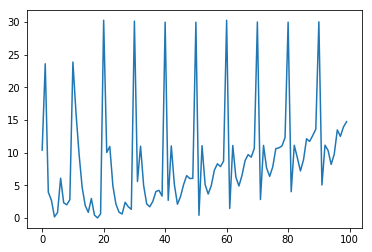

In [39]:
plt.plot(np.absolute(data[:,2]-data[:,3]))
np.absolute(data[:,2]-data[:,3])


In [21]:
aError = 45